In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import copy

In [2]:
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.byol_transform import (
    BYOLTransform,
    BYOLView1Transform,
    BYOLView2Transform,
)
from lightly.utils.scheduler import cosine_schedule
import numpy as np
from lightly.transforms.utils import IMAGENET_NORMALIZE
from lightly.data.dataset import LightlyDataset
from lightly.data._helpers import DatasetFolder, _load_dataset_from_folder
import os

In [3]:
class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(2048, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 512, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

In [4]:

resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
backbone = nn.Sequential(*list(resnet.children())[:-1])
# print(backbone)

model = BYOL(backbone)

/home/sulieman/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print( torch.cuda.is_available())

True


In [6]:
device = "cuda" #if torch.cuda.is_available() else "cpu"
model.to(device)

BYOL(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [7]:

transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(
        input_size=256,
        hf_prob=0.0,
        normalize=None,
        cj_prob=0.0,
        cj_strength=0.0,
        cj_bright=0.0,
        cj_contrast=0.0,
        cj_sat=0.0,
        cj_hue=0.0,
        min_scale=1.0,
        random_gray_scale=0.0,
        gaussian_blur=0.0,
    ),
    view_2_transform=BYOLView2Transform(
        input_size=256, gaussian_blur=1.0, hf_prob=0.0, normalize=None,min_scale=1.0
    ),
)
white_transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(
        input_size=256,
        hf_prob=0.0,
        normalize=None,
        cj_prob=0.0,
        cj_strength=0.0,
        cj_bright=0.0,
        cj_contrast=0.0,
        cj_sat=0.0,
        cj_hue=0.0,
        min_scale=1.0,
        random_gray_scale=0.0,
        gaussian_blur=0.0,
    ),
    view_2_transform=BYOLView1Transform(
        input_size=256,
        hf_prob=0.0,
        normalize=None,
        cj_prob=0.0,
        cj_strength=0.0,
        cj_bright=0.0,
        cj_contrast=0.0,
        cj_sat=0.0,
        cj_hue=0.0,
        min_scale=1.0,
        random_gray_scale=0.0,
        gaussian_blur=0.0,
    ),
)

class mydataset(LightlyDataset):
    def __init__(
        self,
        input_dir,
        transform=None,
        index_to_filename=None,
        filenames=None,
        tqdm_args=None,
        num_workers_video_frame_counting: int = 0,
    ):
        super().__init__(
            input_dir,
            transform,
            index_to_filename,
            filenames,
            tqdm_args,
            num_workers_video_frame_counting,
        )
        # can pass input_dir=None to create an "empty" dataset
        self.input_dir = input_dir

        if self.input_dir is not None:
            self.dataset = _load_dataset_from_folder(
                os.path.join(self.input_dir, "arch"),
                transform,
                is_valid_file=None,
                tqdm_args=tqdm_args,
                num_workers_video_frame_counting=num_workers_video_frame_counting,
            )
            self.white_dataset = _load_dataset_from_folder(
                os.path.join(self.input_dir, "no_back"),
                white_transform,
                is_valid_file=None,
                tqdm_args=tqdm_args,
                num_workers_video_frame_counting=num_workers_video_frame_counting,
            )

    def get_close_far_images(self, image_ind: int, num_im: int):
        inds = np.linspace(0, 600, 601).astype(int)
        close_inds = inds[np.max((image_ind-10 , 0)) : np.min((image_ind+10 , 600))]
        far_inds = inds
        np.delete(
            far_inds,
            np.s_[np.max((image_ind - 30, 0)) : np.min((image_ind + 30, 600))],
            0,
        )
        far_images = []
        close_images = []
        for i in range(num_im):
            far_images.append(far_inds[np.random.randint(0, len(far_inds))])
            close_images.append(close_inds[np.random.randint(0, len(close_inds))])
        return close_images, far_images

    def __getitem__(self, index: int):
        fname = self.index_to_filename(self.dataset, index)

        my_ind = fname.split(".")[0]

        my_ind = int(my_ind)
        close_images, far_images = self.get_close_far_images(my_ind, 5)
        fnames = self.get_filenames()
        far_inds=[]
        close_inds=[]
        for i in range(5):
           far_inds.append(fnames.index(str(far_images[i]) + ".png") )
           close_inds.append(fnames.index(str(close_images[i]) + ".png") )

        sample, target = self.dataset.__getitem__(index)
        close = []
        far = []
        for i in range(5):
            im_close, _ = self.dataset.__getitem__(close_inds[i])
            close.append(im_close[0])
            im_far, _ = self.dataset.__getitem__(far_inds[i])
            far.append(im_far[0])
        white_sample, _ = self.white_dataset.__getitem__(index)




        return sample, target, close, far, white_sample


dataset = mydataset("feat_images", transform=transform)

In [8]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)





In [9]:
sample, target, close,far, white_sample= next(iter(dataloader))
plt.imshow(sample[0][0].permute(1, 2, 0))
plt.axis("off")
plt.show()
plt.imshow(white_sample[0][0].permute(1, 2, 0))
plt.axis("off")
plt.show()

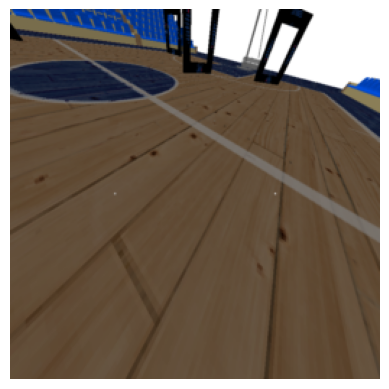

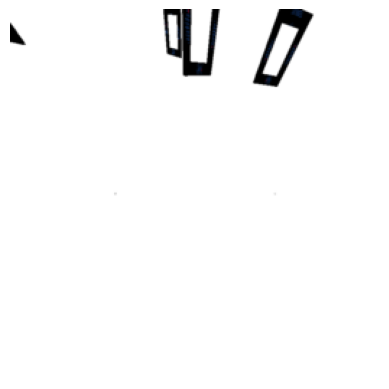

In [11]:
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.9,step_size=1)


In [12]:
from tqdm import tqdm
epochs = 100
from IPython.display import clear_output


 99%|█████████▉| 99/100 [2:55:42<01:41, 101.80s/it]

epoch: 99, loss: -60.34386,LR: 0.000000010


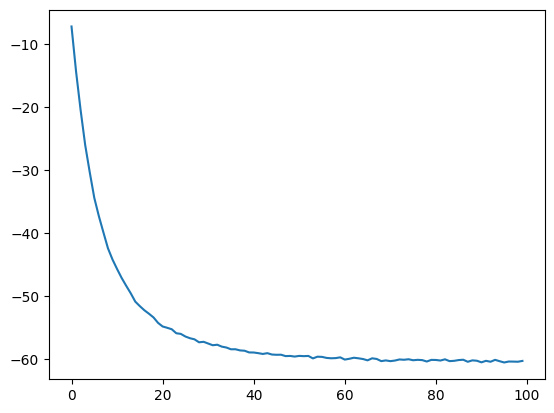

100%|██████████| 100/100 [2:55:43<00:00, 105.43s/it]


In [13]:
print("Starting Training")
it=0
avg_loss=0
losses=[]
for epoch in tqdm(range(epochs)):
    total_loss = 0
    momentum_val =0.9 
    for batch  in dataloader:
        sample, _, close,far, white_sample =batch

        
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(
            model.projection_head, model.projection_head_momentum, m=momentum_val
        )
        x0 = sample[0].to(device)
        x1 = sample[1].to(device)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        x2=white_sample[0].to(device)
        p2=model(x2)
        x3=close[0].to(device)
        p3=model(x3)
        x4=close[1].to(device)
        p4=model(x4)
        x5=close[2].to(device)
        p5=model(x5)
        x6=far[0].to(device)
        p6=model(x6)
        x7=far[1].to(device)
        p7=model(x7)
        x8=far[2].to(device)
        p8=model(x8)
        x9=far[3].to(device)
        p9=model(x9)
        x10=far[4].to(device)
        p10=model(x10)
        lam_01=100.0
        lam_02=100.0
        lam_035=10.0
        lam_0710=1.6
# 
# 
        loss = -torch.log((torch.exp(lam_01*criterion(p0, z0)) + torch.exp(lam_02*criterion(p2,z0))+(torch.exp(lam_035*criterion(p3,z0))+torch.exp(lam_035*criterion(p4,z0))+torch.exp(lam_035*criterion(p5,z0))))/((torch.exp(lam_0710*criterion(p6,z0))+torch.exp(lam_0710*criterion(p7,z0))+torch.exp(lam_0710*criterion(p8,z0))+torch.exp(lam_0710*criterion(p9,z0))+torch.exp(lam_0710*criterion(p10,z0)))))
        optimizer.zero_grad()

        loss.backward()
        total_loss += loss.detach().cpu().item()
        optimizer.step()
        it+=1
    clear_output(wait=False)
    lr=scheduler.get_last_lr()[0]
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    tqdm.write(f"epoch: {epoch:>02}, loss: {avg_loss:.5f},LR: {lr:.9f}")
    plt.plot(losses)
    plt.show()
    
    if(epoch%2==0 and lr>1e-8):

        scheduler.step()


In [14]:
torch.save(model.state_dict(),"feature_model.pth")

In [19]:
from sklearn.manifold import TSNE
features = []
labels = []  # You'll need to provide labels for your data

transform = BYOLView1Transform(
        input_size=256,
        hf_prob=0.0,
        normalize=None,
        cj_prob=0.0,
        cj_strength=0.0,
        cj_bright=0.0,
        cj_contrast=0.0,
        cj_sat=0.0,
        cj_hue=0.0,
        min_scale=1.0,
        random_gray_scale=0.0,
        gaussian_blur=0.0,
    )

with torch.no_grad():
    for i in tqdm(range(5000)):
        images=transform(Image.open("test_images/"+str(i)+".png")).unsqueeze(0)


        images = images.to(device)
        
        batch_features = model.backbone.forward(images).flatten(start_dim=1)
        features.append(batch_features.cpu())


# Stack the features
features = torch.cat(features)
labels = torch.cat(labels)
# Convert features to numpy array
features_np = features.numpy()
# Convert labels to numpy array
labels_np = labels.numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)  # n_components=2 for 2D visualization
tsne_features = tsne.fit_transform(features_np)


100%|██████████| 5000/5000 [01:08<00:00, 72.66it/s]


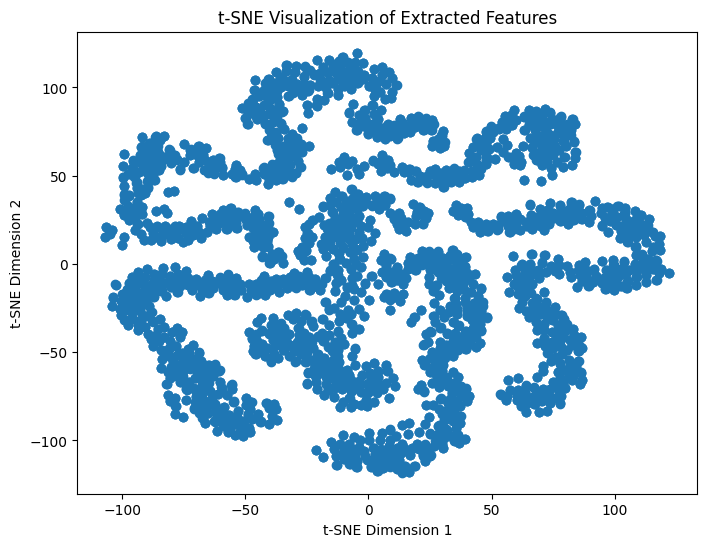

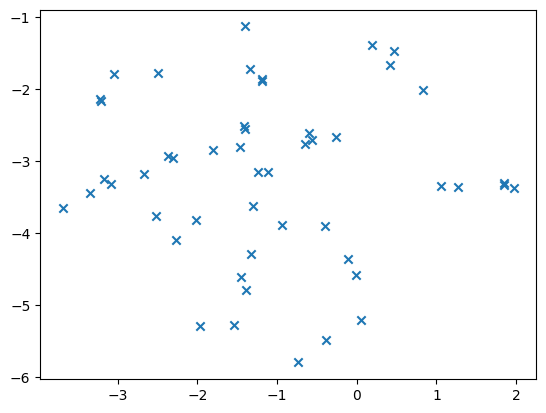

In [20]:

plt.figure(figsize=(8, 6)) 
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], cmap='viridis')
plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
